In [1]:
%matplotlib inline

from matplotlib_inline import backend_inline
import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt
from datetime import datetime
from torch.utils import data
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from IPython.display import display

backend_inline.set_matplotlib_formats('svg')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps')
# device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
# plt.rcParams['font.sans-serif'] = ['SimHei']

## 加载数据

In [2]:
# convert str to datatime
# 将字符串转换为时间
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# load .mat data
# 加载.mat格式的数据
def loadMat(matfile):
    data_mat = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data_mat[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data_mat = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data_mat.append(d1)

    return data_mat

# get capacity data
# 得到电池容量的数据
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]

Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = './dataset/'

Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data_mat = loadMat(path)
    Battery[name] = getBatteryCapacity(data_mat)

Load Dataset B0005.mat ...


/var/folders/xf/z4195tzn5tq20kbd1dlbsg3m0000gn/T/ipykernel_2072/2811494779.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2


Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


In [3]:
len(Battery['B0006'][0]), len(Battery['B0006'][1])

(168, 168)

## 画出数据

/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  func(*args, **kwargs)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  func(*args, **kwargs)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  func(*args, **kwargs)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  func(*args, **kwargs)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: Glyph 23481 (\N{CJK UNIFIED IDEOGRAPH-5BB9}) missing from current font.
  func(*a

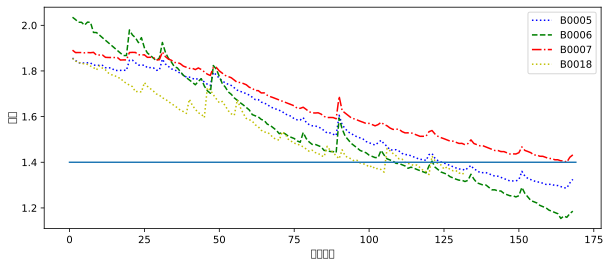

In [4]:
%matplotlib inline

color_list = ['b:', 'g--', 'r-.', 'y:']
# 1.创建画布
plt.figure(figsize=(10, 4), dpi=80)
plt.xlabel('循环次数')
plt.ylabel('容量')

# 2.绘制折线图
for name,color in zip(Battery_list, color_list):
    plt.plot(Battery[name][0], Battery[name][1], color)
    
plt.plot([i for i in range(170)], [1.4] * 170)

# 图例
plt.legend([name for name in Battery_list])

## 构建训练序列数据

In [5]:
# 构建数据
# 采用 留一评估：一组数据为测试集，其他所有数据全部拿来训练
# train_x 的维度是 window_size ，总样本数为 421
# train_y 的维度是1，总样本数为421
# train_data 是模型预测时的真实数据，用来预测下一时刻的容量，长度为 window_size
# test_data 是 真实的容量数据，用来检验模型的各种参数

def build_seq(text, window_size):
    # text:list of capacity
    x, y = [], []
    for i in range(len(text) - window_size):
        sequence = text[i:i + window_size]
        target = text[i + 1:i + window_size + 1]
        x.append(sequence)
        y.append(target)

    return np.array(x), np.array(y)

def get_train_test_data(data_dict, name, window_size=16):
    data_sequence = data_dict[name][1]
    train_data, test_data = data_sequence[:window_size], data_sequence[window_size:]
    
    train_x, train_y = None, None
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_seq(text=v[1], window_size=window_size)
            if train_x is None:
                train_x = data_x
                train_y = data_y
            else:
                train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]

    return train_x, train_y, list(train_data), list(test_data)

def load_capacity_data(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

## 检验 train_iter 数据是否正确

In [6]:
train_x, train_y, train_data, test_data = get_train_test_data(Battery, Battery_list[0], window_size=16)
train_x = torch.from_numpy(train_x.astype(np.float32))
train_y = torch.from_numpy(train_y.astype(np.float32))
train_iter = load_capacity_data((train_x, train_y), 5, is_train=False)

# 测试 train_iter 的数据是否正确
def validate_train_iter(train_iter):
    for x, y in train_iter:
        print(x.shape)
        print(y[:, -1].shape)
        
        print(x)
        print(y[:, -1])
        break



validate_train_iter(train_iter)

torch.Size([5, 16])
torch.Size([5])
tensor([[2.0353, 2.0251, 2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682,
         1.9572, 1.9456, 1.9348, 1.9233, 1.9119, 1.9011, 1.8892],
        [2.0251, 2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572,
         1.9456, 1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783],
        [2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572, 1.9456,
         1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783, 1.8676],
        [2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572, 1.9456, 1.9348,
         1.9233, 1.9119, 1.9011, 1.8892, 1.8783, 1.8676, 1.8676],
        [2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572, 1.9456, 1.9348, 1.9233,
         1.9119, 1.9011, 1.8892, 1.8783, 1.8676, 1.8676, 1.9796]])
tensor([1.8783, 1.8676, 1.8676, 1.9796, 1.9575])


## 创建评估指标函数

In [7]:
# 平均绝对误差、均方根误差
def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse

# 相对误差
# B0005 第125次循环后达到阈值1.4
# B0006 第109次循环后达到阈值1.4
# B0007 数据集中无任何值小于1.4，所以无法达到阈值1.4
# B0018 第97次循环后达到阈值1.4
def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), len(y_predict)
    for i in range(len(y_test) - 1):
        if y_test[i] <= threshold >= y_test[i + 1]:
            true_re = i + 1
            break
    for i in range(len(y_predict) - 1):
        if y_predict[i] <= threshold >= y_predict[i + 1]:
            pred_re = i + 1
            break
    return abs(true_re - pred_re) / true_re

# relative_error(Battery['B0006'][1], Battery['B0006'][1], 1.4)

## 绘制 out 和  tgt_y的对比图

In [8]:
# 绘制 out  tgt_y的对比图
def matlab_make(out, tgt_y):
    color_list = ['b:', 'g:']
    # 1.创建画布
    fig = plt.figure(figsize=(10, 4), dpi=80)
    plt.xlabel('循环次数')
    plt.ylabel('容量')
    
    data_list = [
        {
            'name': 'out',
            'x': [i for i in range(len(out))],
            'y': out
        },
        {
            'name': 'tgt_y',
            'x': [i for i in range(len(tgt_y))],
            'y': tgt_y
        }
    ]

    # 2.绘制折线图
    for data,color in zip(data_list, color_list):
        plt.plot(data['x'], data['y'], color)


    # 图例
    plt.legend([data['name'] for data in data_list])
    
    display(fig)
    plt.close() 

# out_t = [1,2,3,4,5,6,7,8,9,10]
# tgt_y_t = [11,21,31,41,51,61,71,81,91,110]

# matlab_make(out_t, tgt_y_t)

## 2维数据的残差1D卷积网络

In [9]:
# 残差网络
class Residual1D(nn.Module):
    def __init__(self, input_channels, num_channels, kernel_size, strides=1):
        super().__init__()
        
        self.conv1 = nn.Conv1d(input_channels, num_channels, kernel_size=3, stride=strides, padding=1)
        self.conv2 = nn.Conv1d(num_channels, num_channels, kernel_size=3, stride=strides, padding=1)
        
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.bn2 = nn.BatchNorm1d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        
        X = torch.cat([X, X], dim=1)
        
        Y = X + Y
        return F.relu(Y)


    
blk = Residual1D(32, 64, 3)
X = torch.rand(50, 32, 16)
Y = blk(X)
Y.shape

torch.Size([50, 64, 16])

## 搭建模型

In [10]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # 初始化Shape为(max_len, d_model)的PE (positional encoding)
        pe = torch.zeros(max_len, d_model)
        # 初始化一个tensor [[0, 1, 2, 3, ...]]
        position = torch.arange(0, max_len).unsqueeze(1)
        # 这里就是sin和cos括号中的内容，通过e和ln进行了变换
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        # 计算PE(pos, 2i)
        pe[:, 0::2] = torch.sin(position * div_term)
        # 计算PE(pos, 2i+1)
        pe[:, 1::2] = torch.cos(position * div_term)
        # 为了方便计算，在最外面在unsqueeze出一个batch
        pe = pe.unsqueeze(0)
        # 如果一个参数不参与梯度下降，但又希望保存model的时候将其保存下来
        # 这个时候就可以用register_buffer
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x 为embedding后的inputs，例如(1,7, 128)，batch size为1,7个单词，单词维度为128
        """
        # 将x和positional encoding相加。
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)


class Net(nn.Module):

    def __init__(self, d_model=128, nhead=16, num_encoder_layers=2, dim_feedforward=512, kernel_size=3, dropout=0.1):
        super(Net, self).__init__()

        # 定义TransformerEncoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, 
                                                    nhead=nhead, 
                                                    dim_feedforward=dim_feedforward, 
                                                    dropout=dropout, 
                                                    batch_first=True)
        self.transformerEncoder = nn.TransformerEncoder(encoder_layers, num_layers=num_encoder_layers)
        
        self.linear_embedding = nn.Linear(1, d_model)

        # 定义位置编码器
        self.positional_encoding = PositionalEncoding(d_model, dropout=0)
        
        # 残差卷积网络层
        self.rcnn = Residual1D(d_model, d_model * 2, kernel_size=kernel_size)

        # 定义最后的线性层，这里并没有用Softmax，因为没必要。
        # 因为后面的CrossEntropyLoss中自带了
        self.predictor = nn.Linear(d_model * 2, 1)

    def forward(self, x):
        

        # 对 x 进行编码
        x = x.reshape(x.shape[0], x.shape[1], 1)
        
        x = self.linear_embedding(x)
        
        # 给x的token增加位置信息
        x = self.positional_encoding(x)
    
        
        out = self.transformerEncoder(x)
        #print(out.shape)
        
        
        # 残差卷积网络层
        out = out.permute(0, 2, 1)
        out = self.rcnn(out).permute(0, 2, 1) # 输出 out shape: (batch_size, seq_len, d_model * 2)

        out = self.predictor(out)
    
        return out

## 测试模型的输出形状

In [11]:
# 测试模型的输出形状
net = Net(d_model=32).to(device)

# src = torch.LongTensor([[0, 3, 4, 5, 6, 1, 2, 2]])
x = torch.ones((50, 16), dtype=torch.float32).to(device)

out = net(x)
print(out.size())

torch.Size([50, 16, 1])


## 一个批次的训练函数

In [12]:
def train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity): 
    # 将模型设置为训练模式
    net.train()
    
    # 训练损失总和、训练准确度总和、样本数
    for x, y in train_iter:
        # 计算梯度并更新参数
        x = torch.reshape(x, (-1, x.shape[-1])).type(torch.float32)
        y = torch.reshape(y, (-1, y.shape[-1])).type(torch.float32)
        
        x, y = x.to(device), y.to(device)
        #print(src.device)
        #print(tgt.device)
        
        out = net(x)
        
    
        #print('111out', out.shape) # (50, 153, 1)
        # print('111tgt_y', tgt_y.shape) # (50, 153)
        
        l = loss(out.reshape(-1), y.reshape(-1))
        
        #print('222out', out[-1, :, :].cpu().data.numpy().shape) # (50, 153, 1)
        #print('222tgt_y', tgt_y.shape) # (50, 153)
        
        updater.zero_grad()
        l.backward()
        updater.step()
    
    return l

## 总的训练函数

In [13]:
def train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity):
    net = net.to(device)
    
    mae_epoch_list, rmse_epoch_list, re_epoch_list = [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        if (epoch + 1) % 100 == 0:
            pre_list = predict(net, train_data, test_data, Rated_Capacity)
            test_y = test_data.copy()
            
            mae, rmse = evaluation(test_y, pre_list)
            re = relative_error(test_y, pre_list, threshold=Rated_Capacity * 0.7)
            print('epoch:{:<4d} , loss:{:<6.10f} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f}'.format(epoch, train_loss, mae, rmse, re))
            # print('out is ')
            # print(len(out))
            # print('tgt_y is ')
            # print(len(tgt_y))
            
            
            matlab_make(pre_list, test_y)
            
            #print('epoch:{:<4d} , loss:{:<6.10f} '.format(epoch, train_loss))
            
#             if (train_loss < 1e-3) and len(re_epoch_list) > 0 and (re_epoch_list[-1] < re):
#                 break
            
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1]

## 预测函数

In [14]:
def predict(net, train_data, test_data, Rated_Capacity):
    net = net.eval()
    
    x = train_data.copy()
    x = np.array(x)
    x = torch.from_numpy(x).type(torch.float32).to(device)
    x = torch.reshape(x, (1, -1)) # shape: (batch_size, input_size)
    
    pre_list = []
    while len(pre_list) < len(test_data):
        
        
        out = net(x)
        x = torch.cat([x[:, 1:], out[:, -1]], dim=1)
        
        pred = out.reshape(-1)
        
        
        
        pred_next_point = pred.cpu().data.numpy()[-1]
        
        
        pre_list.append(pred_next_point)
        
        
    return pre_list
        
    
# x = train_data.copy()
# pred_list = predict(net, train_data, test_data, 2)
# print((pred_list))
# print((test_data))

# print(len(pred_list))
# print(len(test_data))
# matlab_make(pred_list, test_data)

## 开始训练

以电池 B0005 为测试数据的 数据集 开始训练
epoch:99   , loss:0.0076562189 , MAE:0.3330 , RMSE:0.3722 , RE:0.4624


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

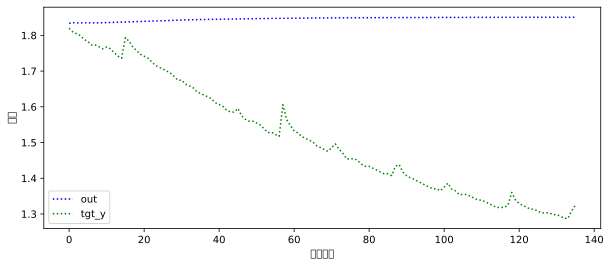

epoch:199  , loss:0.0032871780 , MAE:0.2639 , RMSE:0.3035 , RE:0.4624


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

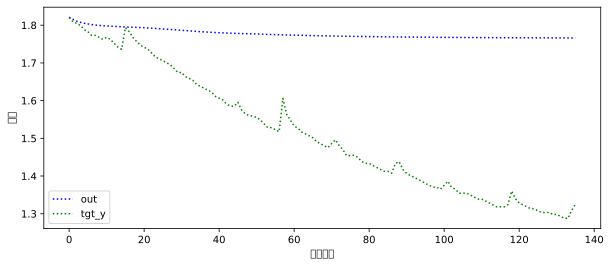

epoch:299  , loss:0.0014983877 , MAE:0.2119 , RMSE:0.2455 , RE:0.4624


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

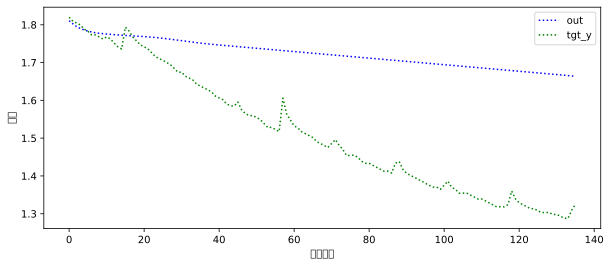

epoch:399  , loss:0.0023020348 , MAE:0.2093 , RMSE:0.2393 , RE:0.4624


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

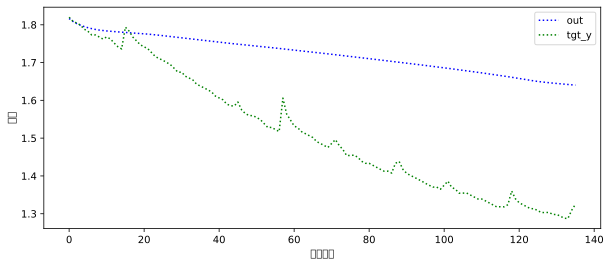

epoch:499  , loss:0.0009637832 , MAE:0.1003 , RMSE:0.1181 , RE:0.4624


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

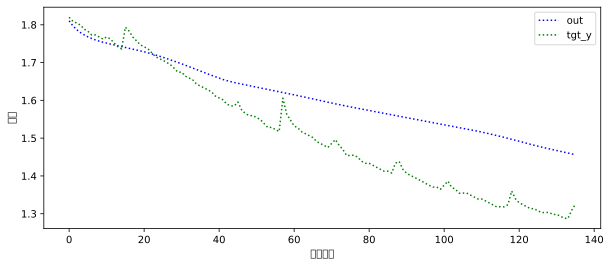

epoch:599  , loss:0.0007714246 , MAE:0.1915 , RMSE:0.2168 , RE:0.4624


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

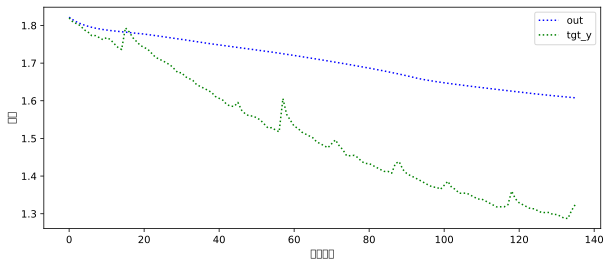

epoch:699  , loss:0.0005735844 , MAE:0.0960 , RMSE:0.1117 , RE:0.4624


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

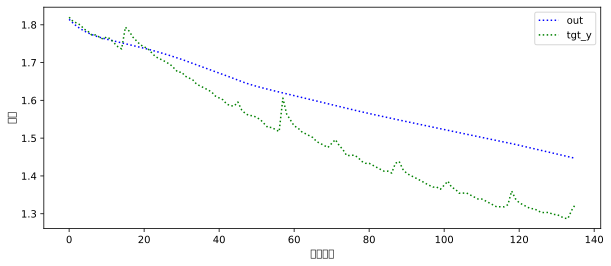

epoch:799  , loss:0.0009519790 , MAE:0.0349 , RMSE:0.0401 , RE:0.1505


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

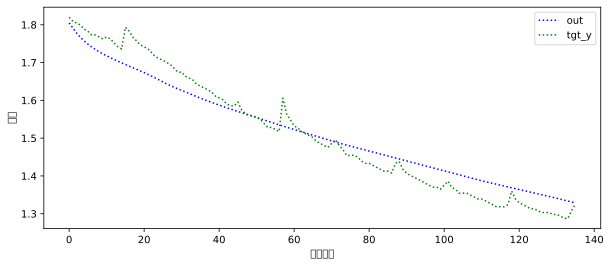

epoch:899  , loss:0.0004006287 , MAE:0.1202 , RMSE:0.1395 , RE:0.4624


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

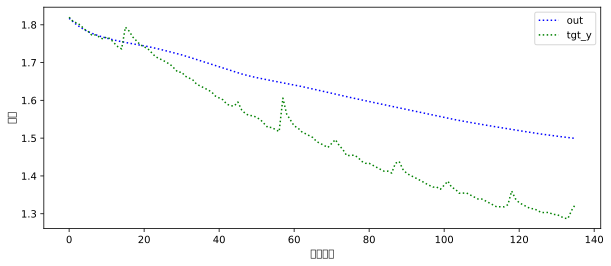

epoch:999  , loss:0.0003159464 , MAE:0.0378 , RMSE:0.0439 , RE:0.2366


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

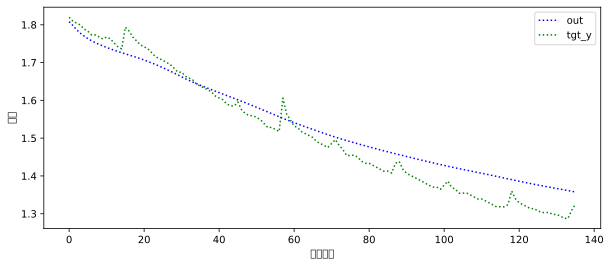

epoch:1099 , loss:0.0003285263 , MAE:0.0441 , RMSE:0.0507 , RE:0.2688


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

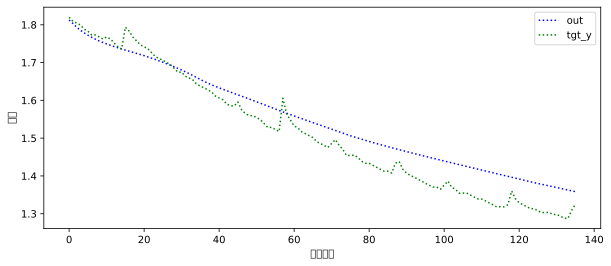

epoch:1199 , loss:0.0004965830 , MAE:0.0272 , RMSE:0.0329 , RE:0.0108


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

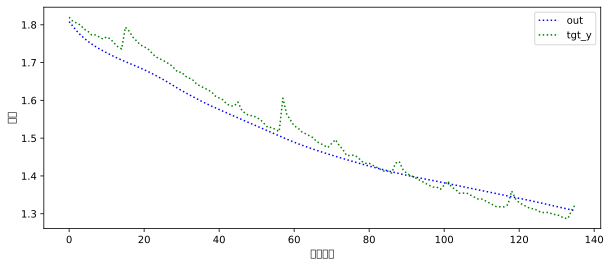

epoch:1299 , loss:0.0002715045 , MAE:0.0379 , RMSE:0.0461 , RE:0.2688


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

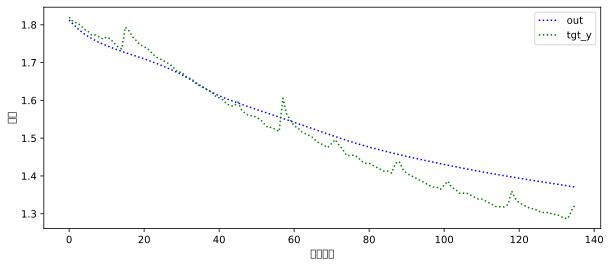

epoch:1399 , loss:0.0001819640 , MAE:0.0912 , RMSE:0.1037 , RE:0.4624


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

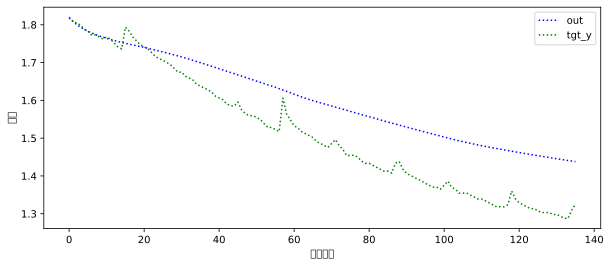

epoch:1499 , loss:0.0001507388 , MAE:0.0223 , RMSE:0.0277 , RE:0.0323


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

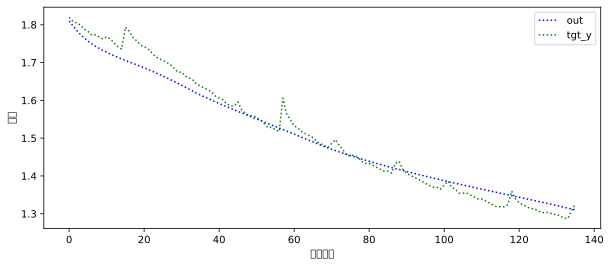

epoch:1599 , loss:0.0001084975 , MAE:0.0246 , RMSE:0.0298 , RE:0.0645


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

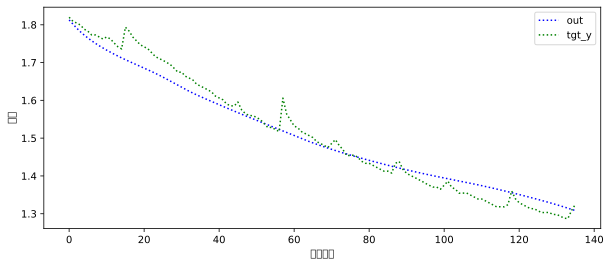

epoch:1699 , loss:0.0001139426 , MAE:0.0622 , RMSE:0.0731 , RE:0.4624


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

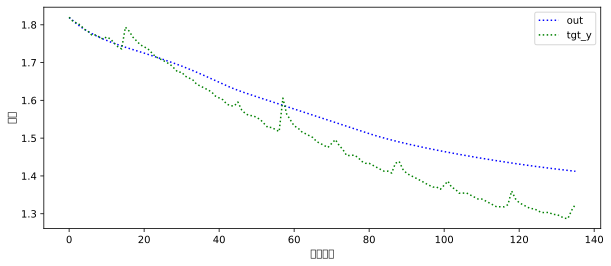

epoch:1799 , loss:0.0000940998 , MAE:0.1590 , RMSE:0.1807 , RE:0.4624


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

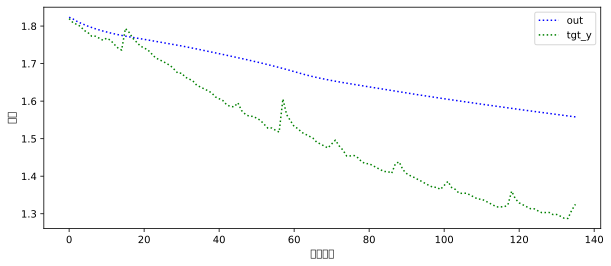

epoch:1899 , loss:0.0000996574 , MAE:0.0424 , RMSE:0.0526 , RE:0.3871


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

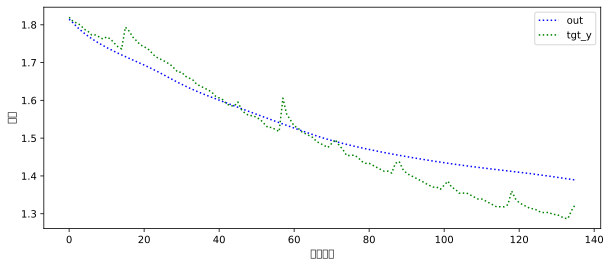

epoch:1999 , loss:0.0000732261 , MAE:0.0547 , RMSE:0.0664 , RE:0.4624


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

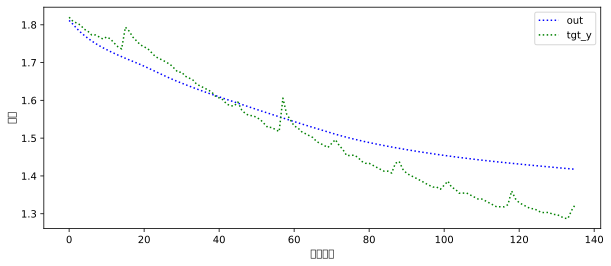

以电池 B0006 为测试数据的 数据集 开始训练
epoch:99   , loss:0.0070326617 , MAE:0.3035 , RMSE:0.3285 , RE:0.7662


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

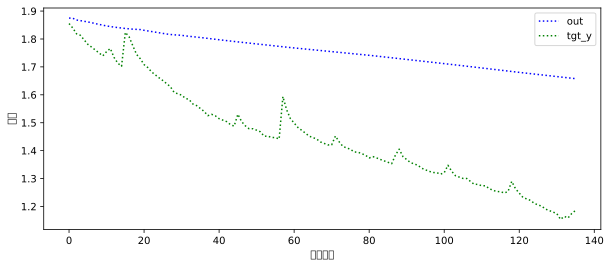

epoch:199  , loss:0.0039708852 , MAE:0.2348 , RMSE:0.2514 , RE:0.7662


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

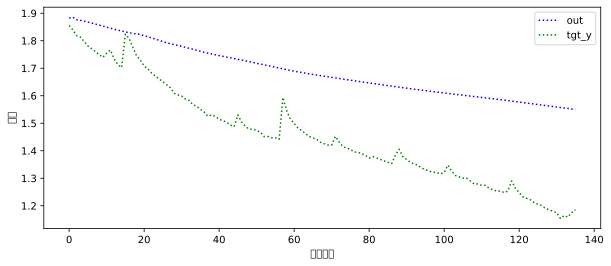

epoch:299  , loss:0.0019948494 , MAE:0.2653 , RMSE:0.2834 , RE:0.7662


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

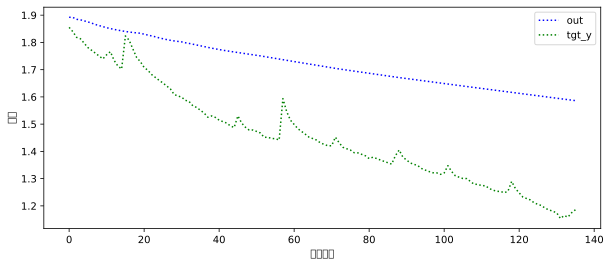

epoch:399  , loss:0.0012810030 , MAE:0.2105 , RMSE:0.2215 , RE:0.7662


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

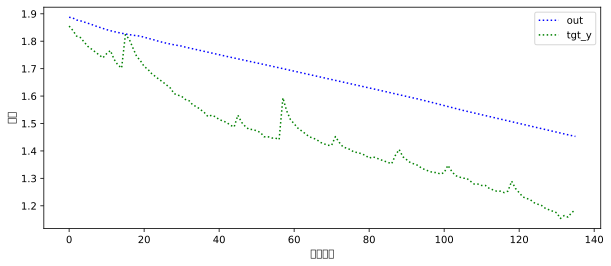

epoch:499  , loss:0.0019126396 , MAE:0.3414 , RMSE:0.3618 , RE:0.7662


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

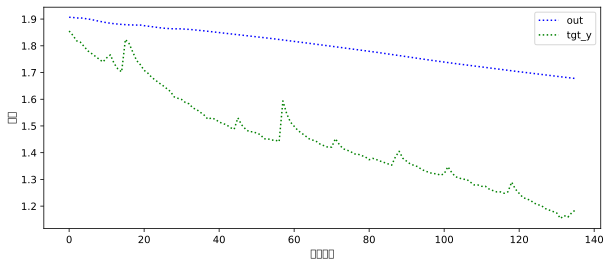

epoch:599  , loss:0.0007774805 , MAE:0.2822 , RMSE:0.2968 , RE:0.7662


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

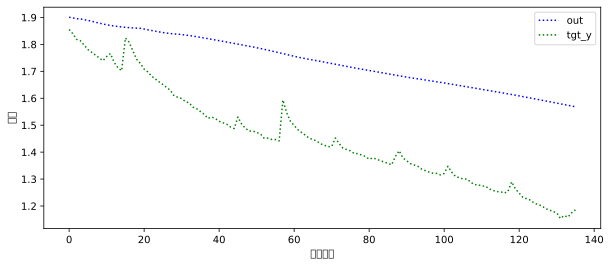

epoch:699  , loss:0.0008035488 , MAE:0.3494 , RMSE:0.3702 , RE:0.7662


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

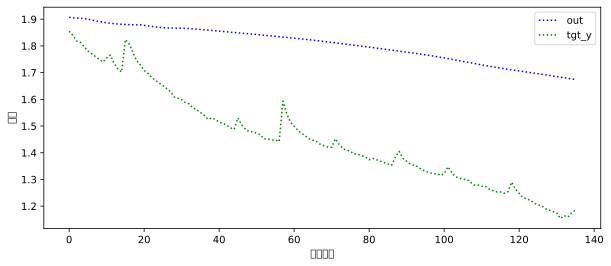

epoch:799  , loss:0.0008876673 , MAE:0.2966 , RMSE:0.3132 , RE:0.7662


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

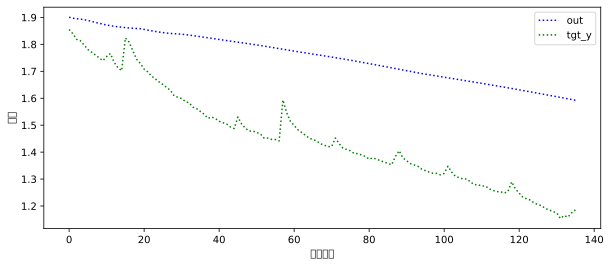

epoch:899  , loss:0.0006161569 , MAE:0.1538 , RMSE:0.1611 , RE:0.5974


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

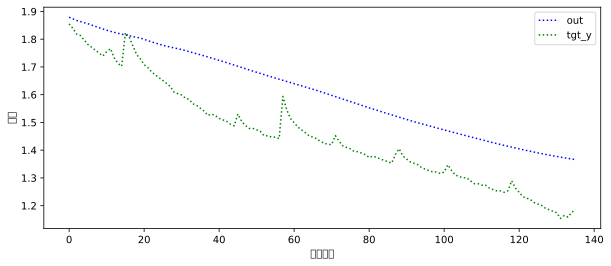

epoch:999  , loss:0.0005467923 , MAE:0.1446 , RMSE:0.1522 , RE:0.5844


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

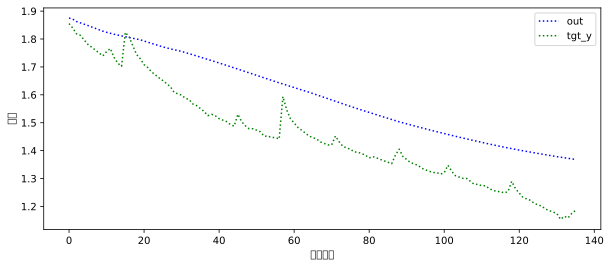

epoch:1099 , loss:0.0004088582 , MAE:0.1681 , RMSE:0.1758 , RE:0.7273


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

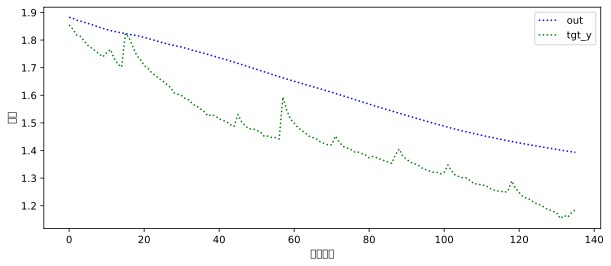

epoch:1199 , loss:0.0004250549 , MAE:0.1344 , RMSE:0.1415 , RE:0.5065


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

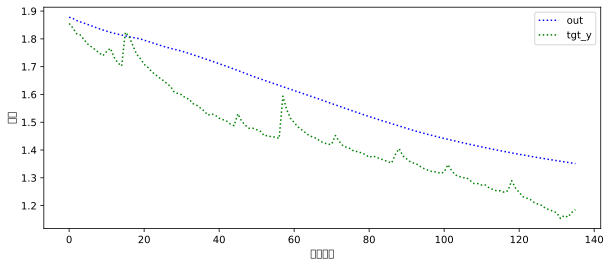

epoch:1299 , loss:0.0005079561 , MAE:0.1927 , RMSE:0.2019 , RE:0.7662


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

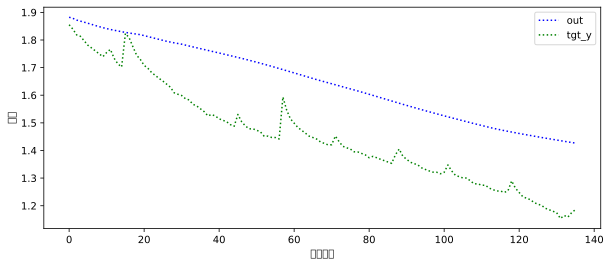

epoch:1399 , loss:0.0003659649 , MAE:0.1754 , RMSE:0.1837 , RE:0.7662


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

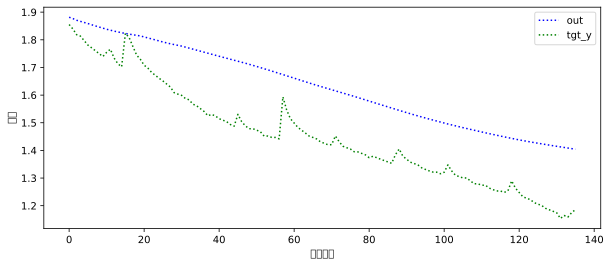

epoch:1499 , loss:0.0002992615 , MAE:0.1836 , RMSE:0.1918 , RE:0.7532


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

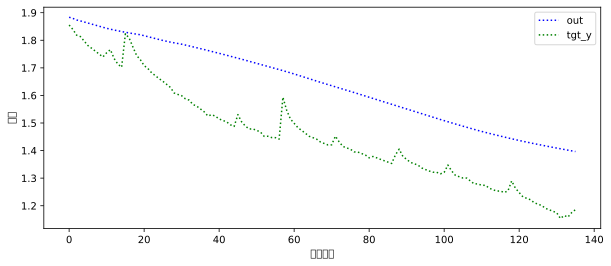

epoch:1599 , loss:0.0002297000 , MAE:0.2308 , RMSE:0.2418 , RE:0.7662


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

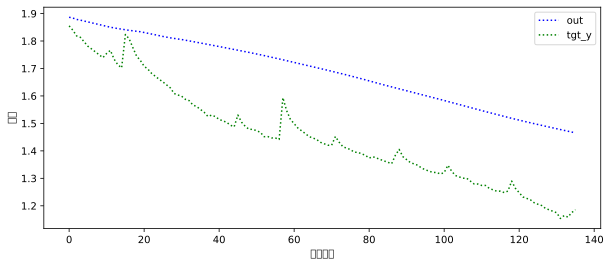

epoch:1699 , loss:0.0002606084 , MAE:0.1521 , RMSE:0.1597 , RE:0.6234


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

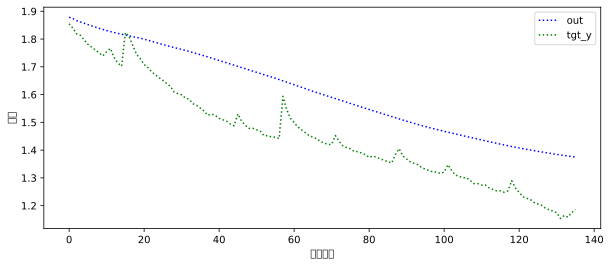

epoch:1799 , loss:0.0002263643 , MAE:0.2348 , RMSE:0.2464 , RE:0.7662


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

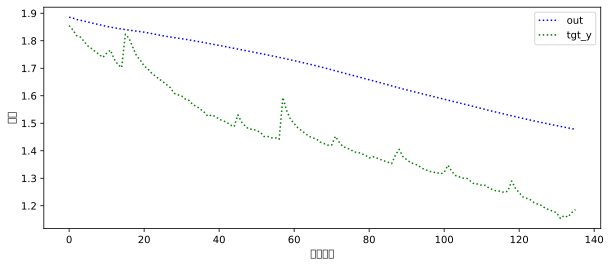

epoch:1899 , loss:0.0002253130 , MAE:0.1018 , RMSE:0.1095 , RE:0.2987


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

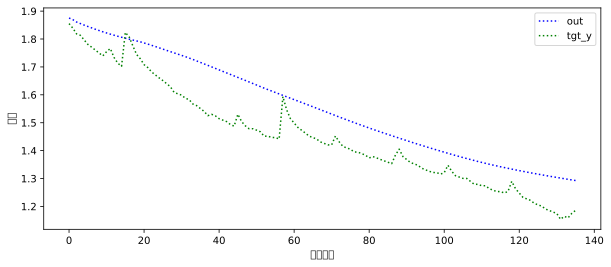

epoch:1999 , loss:0.0001801562 , MAE:0.1688 , RMSE:0.1767 , RE:0.6494


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

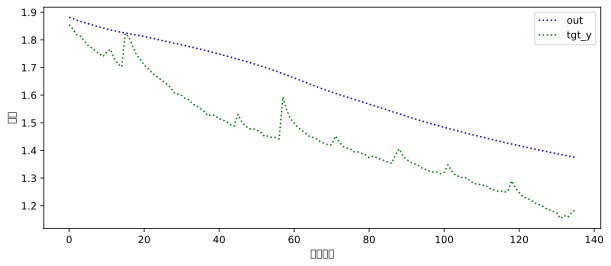

以电池 B0007 为测试数据的 数据集 开始训练
epoch:99   , loss:0.0118292598 , MAE:0.0443 , RMSE:0.0515 , RE:0.0000


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

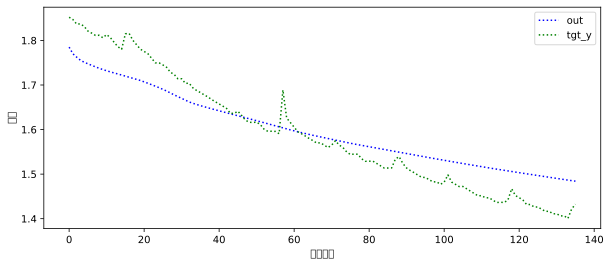

epoch:199  , loss:0.0020011563 , MAE:0.0439 , RMSE:0.0475 , RE:0.0000


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

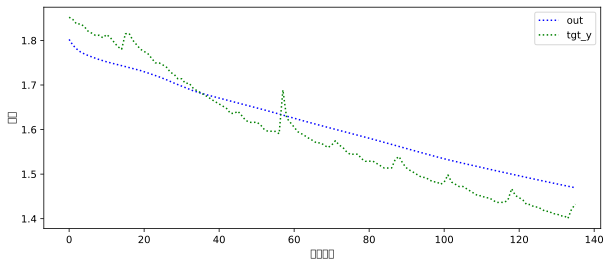

epoch:299  , loss:0.0049275351 , MAE:0.1712 , RMSE:0.1880 , RE:0.4559


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

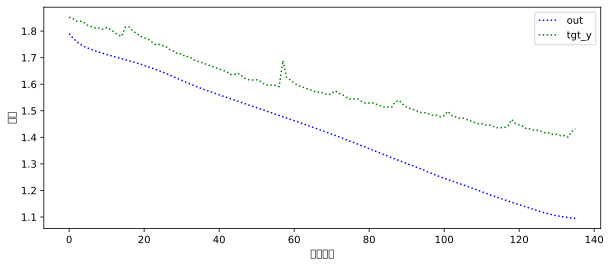

epoch:399  , loss:0.0024955627 , MAE:0.1573 , RMSE:0.1717 , RE:0.4338


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

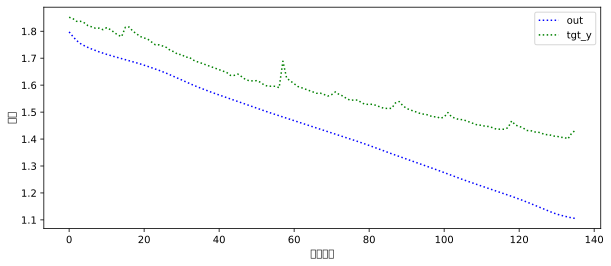

epoch:499  , loss:0.0017705181 , MAE:0.0364 , RMSE:0.0399 , RE:0.0000


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

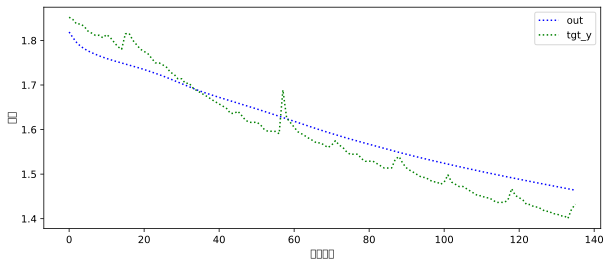

epoch:599  , loss:0.0010014268 , MAE:0.0351 , RMSE:0.0389 , RE:0.0809


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

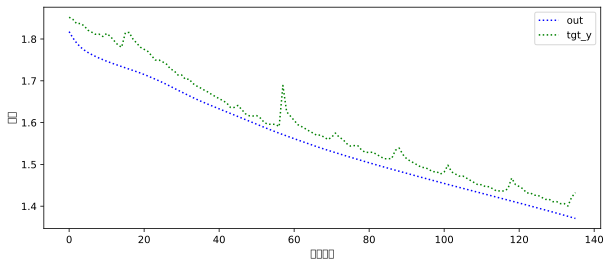

epoch:699  , loss:0.0005259747 , MAE:0.0523 , RMSE:0.0549 , RE:0.1838


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

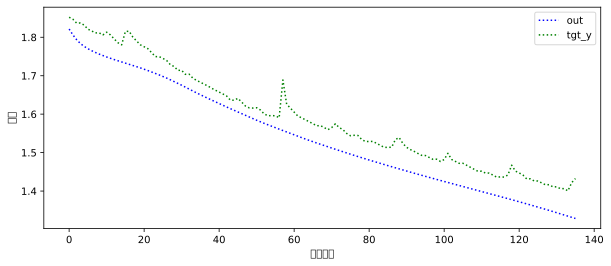

epoch:799  , loss:0.0006974728 , MAE:0.0958 , RMSE:0.1009 , RE:0.3309


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

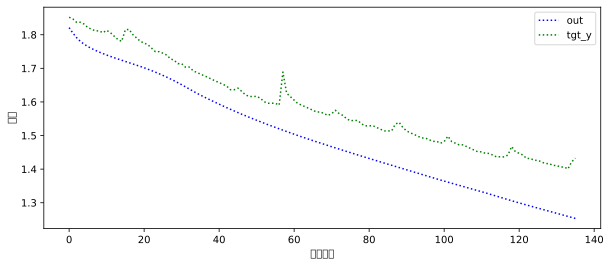

epoch:899  , loss:0.0003804391 , MAE:0.0918 , RMSE:0.0980 , RE:0.3382


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

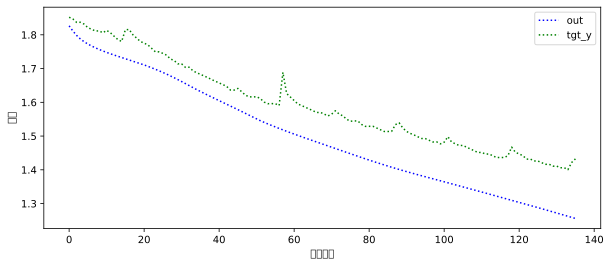

epoch:999  , loss:0.0002540806 , MAE:0.1202 , RMSE:0.1284 , RE:0.4044


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

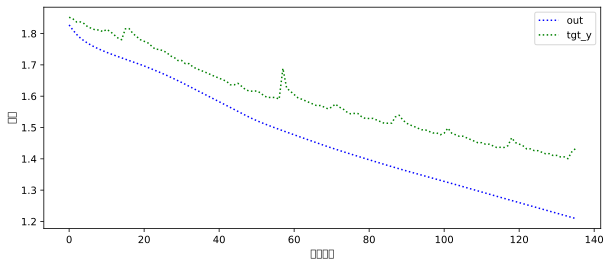

epoch:1099 , loss:0.0002242355 , MAE:0.1553 , RMSE:0.1641 , RE:0.4853


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

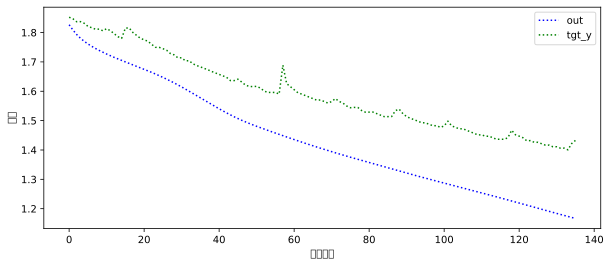

epoch:1199 , loss:0.0002483975 , MAE:0.0780 , RMSE:0.0837 , RE:0.3088


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

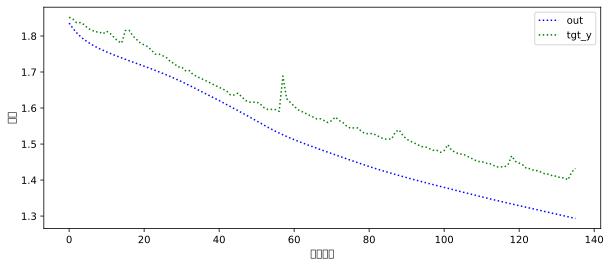

epoch:1299 , loss:0.0002007822 , MAE:0.0587 , RMSE:0.0657 , RE:0.2574


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

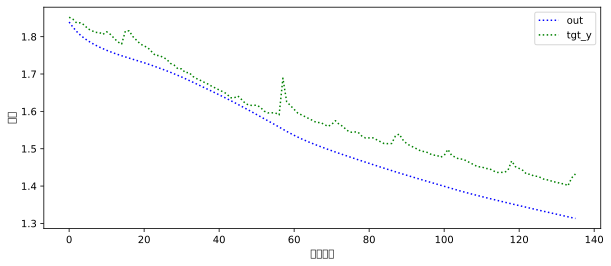

epoch:1399 , loss:0.0001885891 , MAE:0.1411 , RMSE:0.1498 , RE:0.4632


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

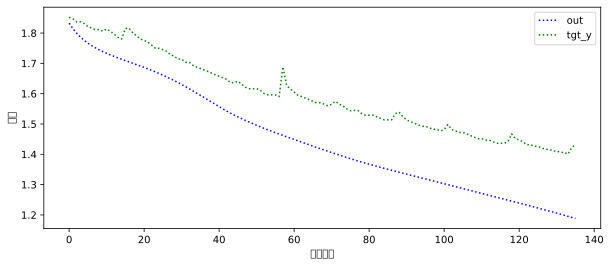

epoch:1499 , loss:0.0001069843 , MAE:0.1554 , RMSE:0.1674 , RE:0.4853


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

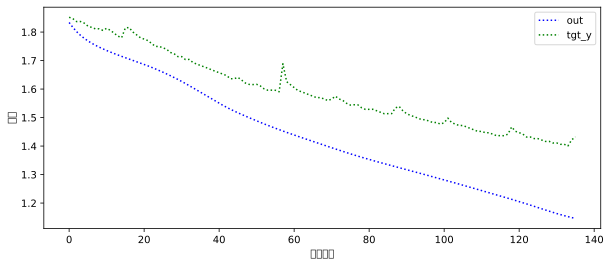

epoch:1599 , loss:0.0001206289 , MAE:0.0291 , RMSE:0.0323 , RE:0.1176


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

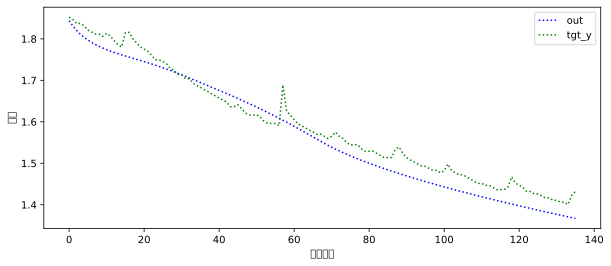

epoch:1699 , loss:0.0001059017 , MAE:0.1480 , RMSE:0.1594 , RE:0.4706


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

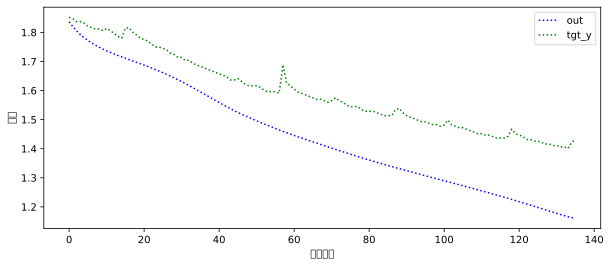

epoch:1799 , loss:0.0001040764 , MAE:0.1354 , RMSE:0.1464 , RE:0.4412


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

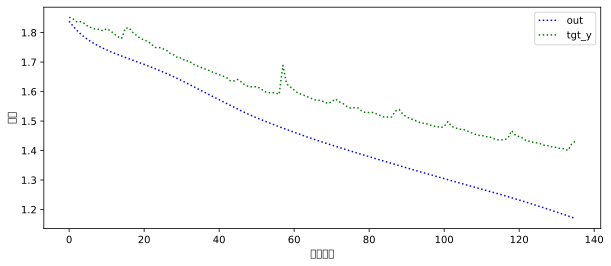

epoch:1899 , loss:0.0000840180 , MAE:0.0725 , RMSE:0.0818 , RE:0.3015


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

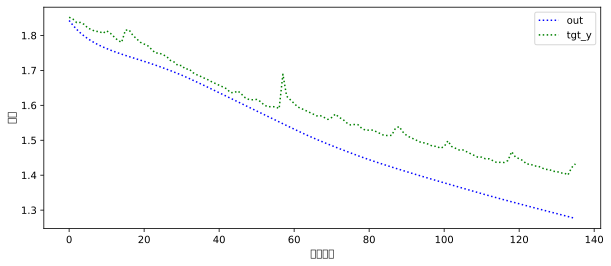

epoch:1999 , loss:0.0000777574 , MAE:0.0474 , RMSE:0.0557 , RE:0.2206


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

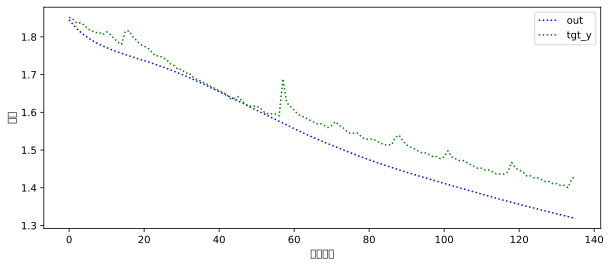

以电池 B0018 为测试数据的 数据集 开始训练
epoch:99   , loss:0.0176307373 , MAE:0.2885 , RMSE:0.3141 , RE:0.5385


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

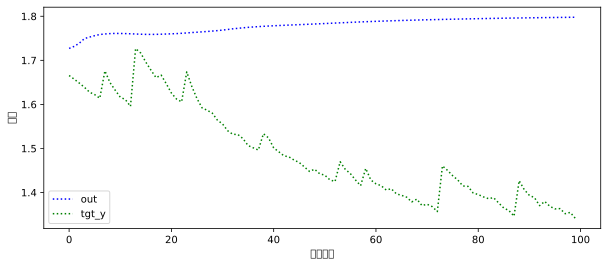

epoch:199  , loss:0.0037553047 , MAE:0.2616 , RMSE:0.2859 , RE:0.5385


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

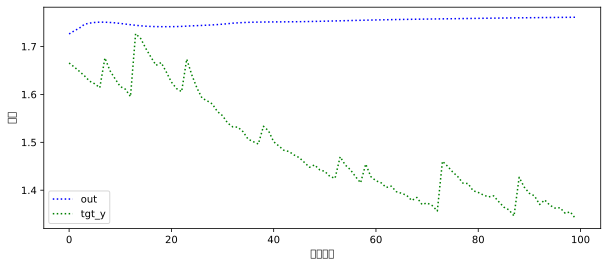

epoch:299  , loss:0.0054378523 , MAE:0.2303 , RMSE:0.2527 , RE:0.5385


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

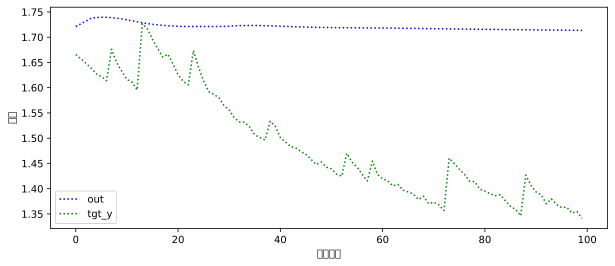

epoch:399  , loss:0.0027514801 , MAE:0.2861 , RMSE:0.3127 , RE:0.5385


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

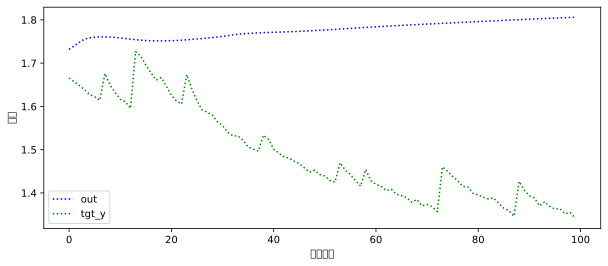

epoch:499  , loss:0.0014635774 , MAE:0.1632 , RMSE:0.1761 , RE:0.5385


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

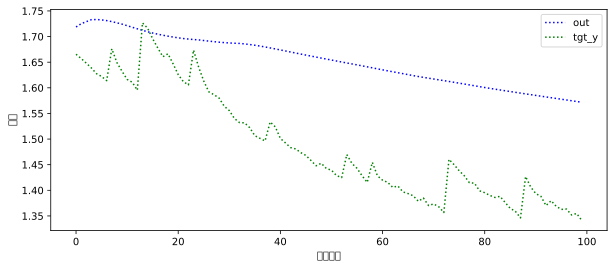

epoch:599  , loss:0.0012297746 , MAE:0.0447 , RMSE:0.0576 , RE:0.0615


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

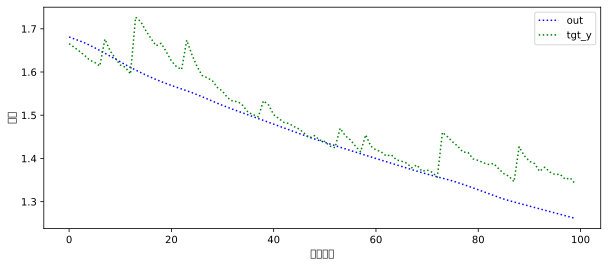

epoch:699  , loss:0.0007967523 , MAE:0.0337 , RMSE:0.0397 , RE:0.2462


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

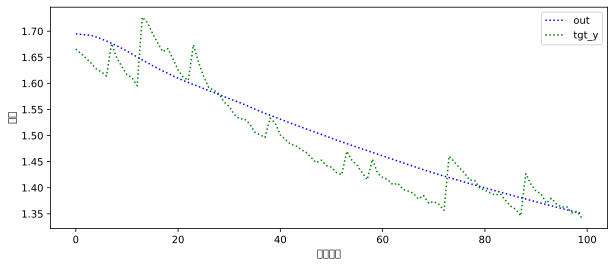

epoch:799  , loss:0.0009769737 , MAE:0.0321 , RMSE:0.0376 , RE:0.0923


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

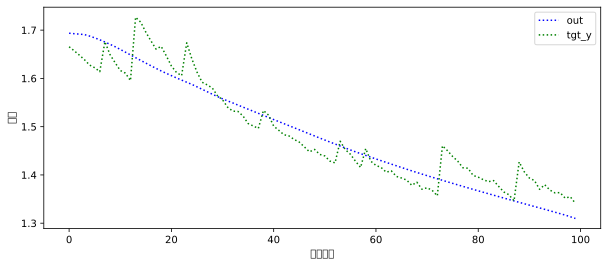

epoch:899  , loss:0.0010807730 , MAE:0.0895 , RMSE:0.0975 , RE:0.5385


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

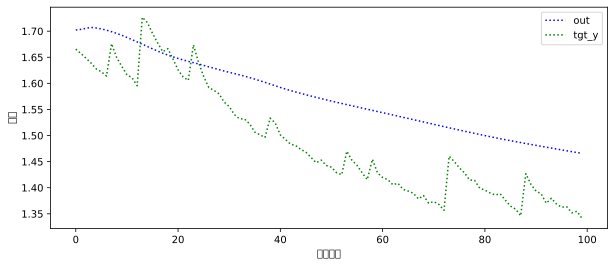

epoch:999  , loss:0.0007324696 , MAE:0.0317 , RMSE:0.0373 , RE:0.2154


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

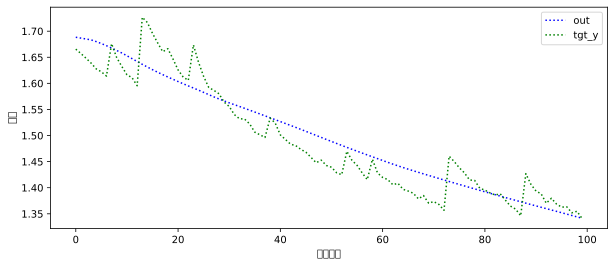

epoch:1099 , loss:0.0003516657 , MAE:0.0490 , RMSE:0.0553 , RE:0.5231


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

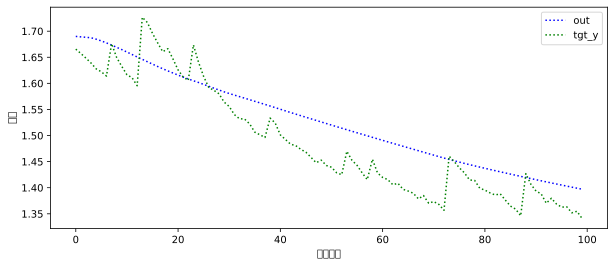

epoch:1199 , loss:0.0005703545 , MAE:0.0478 , RMSE:0.0543 , RE:0.4615


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

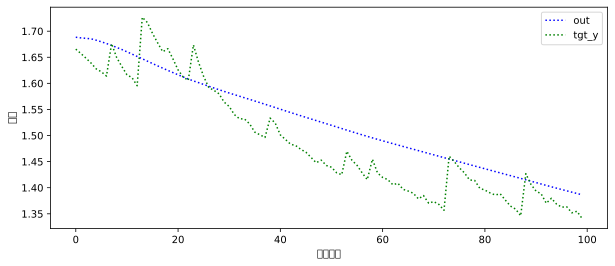

epoch:1299 , loss:0.0003068215 , MAE:0.1261 , RMSE:0.1373 , RE:0.5385


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

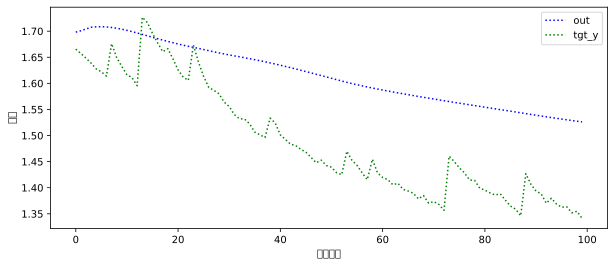

epoch:1399 , loss:0.0003603653 , MAE:0.0326 , RMSE:0.0388 , RE:0.1538


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

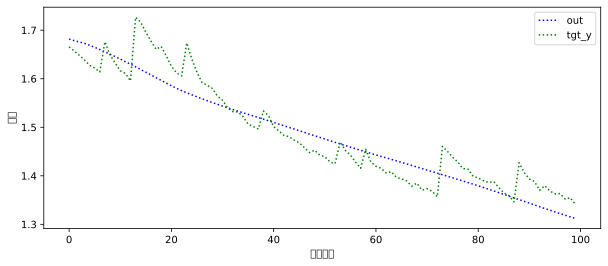

epoch:1499 , loss:0.0003181396 , MAE:0.0330 , RMSE:0.0394 , RE:0.1692


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

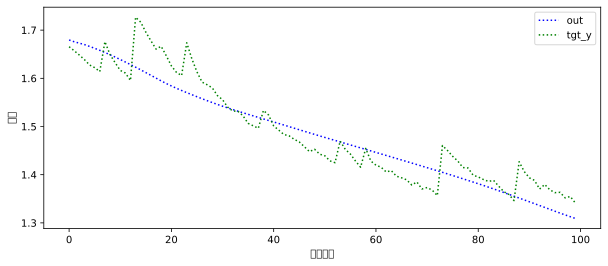

epoch:1599 , loss:0.0003311025 , MAE:0.0841 , RMSE:0.0923 , RE:0.5385


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

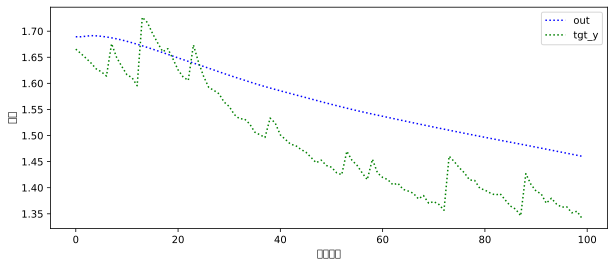

epoch:1699 , loss:0.0003267462 , MAE:0.0360 , RMSE:0.0433 , RE:0.0923


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

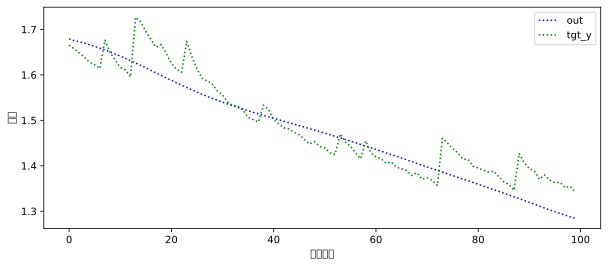

epoch:1799 , loss:0.0002518670 , MAE:0.0347 , RMSE:0.0396 , RE:0.1538


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

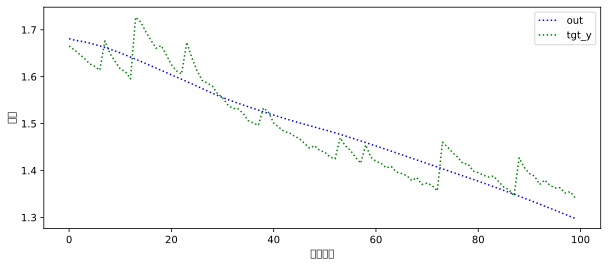

epoch:1899 , loss:0.0002092077 , MAE:0.0319 , RMSE:0.0386 , RE:0.2000


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

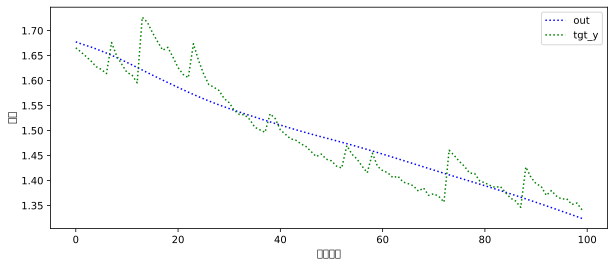

epoch:1999 , loss:0.0002702158 , MAE:0.1192 , RMSE:0.1407 , RE:0.2769


/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24490 (\N{CJK UNIFIED IDEOGRAPH-5FAA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29615 (\N{CJK UNIFIED IDEOGRAPH-73AF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/coyle/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

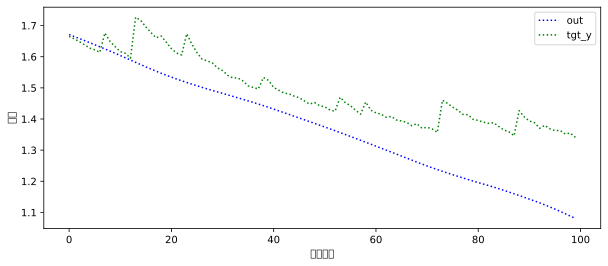

---------------------------------
re_s [0.46236559139784944, 0.6493506493506493, 0.22058823529411764, 0.27692307692307694]
---------------------------------
re mean: 0.40230688824142335
mae mean: 0.09750183032240844
rmse mean: 0.10989354566138942
---------------------------------


In [16]:
# 电池额定容量
Rated_Capacity = 2.0

# 超参数
d_model = 32
nhead = 8
num_encoder_layers = 2
dim_feedforward = 64

batch_size = 50
lr = 0.0001
weight_decay = 0.00001
num_epochs = 2000
window_size = 32

# 获取数据集，生成train_iter
# 使用留一评估
mae_s, rmse_s, re_s = [], [], []
for i in range(4):
# for i in range(1):
    train_x, train_y, train_data, test_data = get_train_test_data(Battery, Battery_list[i], window_size=window_size)
    train_x = torch.from_numpy(train_x.astype(np.float32))
    train_y = torch.from_numpy(train_y.astype(np.float32))
    train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=True)
    
    # 模型、损失函数、优化器
    net = Net(d_model=d_model, nhead=nhead,
              num_encoder_layers=num_encoder_layers, 
              dim_feedforward=dim_feedforward)
    loss = nn.MSELoss()
    updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

    # 开始训练
    print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
    #train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
    mae, rmse, re = train(net, train_iter, train_data, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
    mae_s.append(mae)
    rmse_s.append(rmse)
    re_s.append(re)

print('---------------------------------')
print('re_s', re_s)
print('---------------------------------')
print(f're mean: {np.array(re_s).mean()}')
print(f'mae mean: {np.array(mae_s).mean()}')
print(f'rmse mean: {np.array(rmse_s).mean()}')
print('---------------------------------')